# Lac Pavin diversity

In [8]:
import matplotlib, re, os, glob, datetime, difflib, random, time, math, json, wget
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
from collections import defaultdict
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO, SeqUtils, SearchIO

In [9]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def encode(path):
    return "A" + "".join(os.path.basename(path).split("_")[1:3])      

In [10]:
def categorize(sample_name):
    
    if "SED" in sample_name:
        return "sediment"
    elif "12" in sample_name:
        return "shallow"
    elif "70" in sample_name or "90" in sample_name:
        return "anoxic zone"
    else: return "interface"

In [11]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"

# define data sources

In [12]:
# gather read files
reads = {"water_column":[], "sediment":[]}

# project dir
for sample in glob.glob(rootdir.replace("analysis/", "QB3*/raw.d/*/")):
    if (("Creux" not in sample) and ("07_03" not in sample)):
        fwd = glob.glob(sample + "/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "/*.PE.2.fastq.gz")[0]
        reads["water_column"].append((fwd,rev))

# /banfield/sequences
for sample in glob.glob("/groups/banfield/sequences/2020/LacPavin*/"):
    if "ALN" not in sample:
        fwd = glob.glob(sample + "raw.d/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "raw.d/*.PE.2.fastq.gz")[0]
        if "SED" in sample:
            reads["sediment"].append((fwd, rev))
        else: reads["water_column"].append((fwd, rev))

In [13]:
# define samples/assemblies of interest
assemblies = {"water_column":[], "sediment":[]}
for assembly in glob.glob(rootdir.replace("analysis/", "QB3*/assembly.d/*/*megahit*/*min1000.fa")):
    if ("Creux" not in assembly) and ("ALN" not in assembly):
        if "SED" in assembly:
            assemblies["sediment"].append(assembly)
        else: assemblies["water_column"].append(assembly)

# marker gene - assembled

In [16]:
divdir = rootdir + "/diversity/"
cmdir(divdir)

### extract + threshold s3

In [ ]:
cmdir(divdir + "hmm")

In [14]:
def parse_hmm(result_table):
    
    temp = {}
    count = 0
    
    # parse each result file using searchio
    for result in SearchIO.parse(result_table, "hmmer3-tab"):
        for item in result.hits:
            temp[count] = {"gene": item.id, "hmm": item.query_id, "score": item.bitscore, "eval": item.evalue}
            count += 1
            
    return(pd.DataFrame.from_dict(temp, orient="index"))

In [ ]:
for biome in assemblies:
    
    for assembly in assemblies[biome]:
        
        protein_path = assembly.replace(".fa",".fa.genes.faa")
        result_file = divdir + "hmm/" + encode(assembly) + ".results"
        hmm_path = "/groups/banfield/users/sdiamond/database/Custom_HMM/rpS3/rpS3_noEuk_NR90_min200.fasta.aln.hmm"
        call = "hmmsearch --cpu 16 --tblout " + result_file + " " + hmm_path + " " + protein_path
        sp.call(call, shell=True)

In [17]:
hmm_results = {}

for hmm_result in glob.glob(divdir + "/hmm/*results"):
    hmm_results[os.path.basename(hmm_result).split(".")[0]] = parse_hmm(hmm_result)

In [18]:
filtered_hmm_results = {}

for biome in assemblies:
    
    for assembly in assemblies[biome]:

        key = encode(assembly)
        # apply threshold
        table = hmm_results[key]
        filtered_table = table[table["score"] >= 40]
        filtered_hmm_results[key] = filtered_table

        #then write out new sequences
        with open(divdir + "hmm/" + key + ".filtered.txt", "w") as outfile:

            for index, row in filtered_table.iterrows():
                outfile.write(row["gene"] + "\n")

        # N.B - file appends so need to clear before rerun
        call = "pullseq -n " + divdir + "hmm/" + key + ".filtered.txt" + " -i " + \
            assembly.replace(".fa",".fa.genes.faa") + " >> " + \
            divdir + "hmm/rps3.filtered.cat.faa"
        sp.call(call, shell=True)

### cluster

In [ ]:
cmdir(divdir + "clustering")

In [ ]:
# clustering
call = "usearch -cluster_fast " + divdir + "hmm/rps3.filtered.cat.faa" + " -sort length -id 0.99 " + \
    "-maxrejects 0 -maxaccepts 0 -centroids " + divdir + "clustering/rps3.cat.centroids -uc " + \
    divdir + "/clustering/rps3.cat.clusters"
sp.call(call, shell=True)

In [19]:
## from RpxSuite - https://github.com/alexcritschristoph/
    ##RPxSuite/blob/master/rpXsuite/RPxSuite.py

def parse_usearch_clustering(loc):

    dtypes = {0:'category', 1:'category', 2:np.int32, 8:'object'}
    ucols = [0,1,2,8]
    Rdb = pd.read_csv(loc, header=None, usecols=ucols,\
            dtype=dtypes, sep='\t')
    table = defaultdict(list)

    # Find the centroids
    sdb  = Rdb[Rdb[0] == 'S']
    shdb = Rdb[Rdb[0].isin(['H', 'S'])]
    for centroid, cdb in sdb.groupby(1):
        cent = cdb[8].tolist()[0].split()[0]
        db = shdb[shdb[1] == centroid]

        for seq in db[8].tolist():
            table['cluster'].append(int(centroid))
            table['members'].append(len(db))
            table['sequence'].append(seq.split()[0])
            table['centroid'].append(cent)

    return pd.DataFrame(table)

In [177]:
cluster_results = parse_usearch_clustering(divdir + "clustering/rps3.cat.clusters")
len(cluster_results["cluster"].unique())

2244

### select clusters

In [179]:
#build contig len db
scaflens = {}
for biome in assemblies:
    for assembly in assemblies[biome]:
        for record in SeqIO.parse(open(assembly), "fasta"):
            scaflens[record.description.split(" ")[0]] = len(record.seq)

In [180]:
# choosing representative scaffold
cluster2scaf = defaultdict(list)

for key, info in cluster_results.groupby("cluster"):
    
    temp = []
    for sequence in info["sequence"].to_list():
        scaf = scaffold(sequence)
        temp.append({"name":scaf, "len":scaflens[scaf]})
    
    temps = sorted(temp, key = lambda x: x['len'], reverse=True)
    
    cluster2scaf["cluster"].append(key)
    cluster2scaf["longest_scaf"].append(temps[0]["name"])
    cluster2scaf["longest_scaflen"].append(temps[0]["len"])

# clear dict
scaflens = []

In [181]:
cdf = pd.DataFrame(cluster2scaf)
cmerge = cdf.merge(cluster_results[["cluster", "centroid", "members"]]).drop_duplicates()
cmerge["species_group"] = cmerge["cluster"].apply(lambda x: "sg" + str(x+1))
cmerge.head()

,cluster,longest_scaf,longest_scaflen,centroid,members,species_group
0,0,LacPavin_0818_WC45_scaffold_189701,16321,LacPavin_0818_WC45_scaffold_189701_6,1,sg1
1,1,LacPavin_0818_WC45_scaffold_859772,5540,LacPavin_0818_WC45_scaffold_859772_1,3,sg2
4,2,LacPavin_0818_WC45_scaffold_888939,7141,LacPavin_0818_WC45_scaffold_888939_3,1,sg3
5,3,LacPavin_0920_SED2_scaffold_1559493,2325,LacPavin_0920_SED2_scaffold_1559493_3,1,sg4
6,4,LacPavin_0818_WC45_scaffold_370292,11251,LacPavin_0818_WC45_scaffold_370292_5,1,sg5


### cluster filtering

In [182]:
# filter out partial genes making duplicate sg's per scaf
len_dict = {record.description.split(" ")[0]: len(record.seq) 
    for record in SeqIO.parse(open(divdir+"hmm/rps3.filtered.cat.faa"), "fasta")}
cmerge["centroid_len"] = cmerge["centroid"].map(len_dict)
# then filter out dups, taking largest chunk
cmerge = cmerge.sort_values("centroid_len", ascending=False).drop_duplicates("longest_scaf")

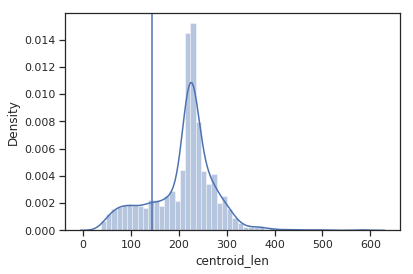

In [183]:
#size filter / partials
sns.distplot(cmerge["centroid_len"])
plt.axvline(np.mean(cmerge["centroid_len"]) - 1*np.std(cmerge["centroid_len"]))
plt.show()

In [184]:
#for now, filter at > 1 STD below the mean
thresh = np.mean(cmerge["centroid_len"]) - 1*np.std(cmerge["centroid_len"])
cmerge = cmerge[cmerge["centroid_len"] >= thresh]

### assign taxonomy

In [185]:
cmerge["sample"] = cmerge["longest_scaf"].apply(lambda x: "_".join(x.split("_")[0:3]))

In [ ]:
# write out scaffold genes

with open(divdir + "all_marker_scaffold_proteins.faa", "w") as out:
    
    for biome in assemblies:
        for assembly in assemblies[biome]:
            
            name = "_".join(os.path.basename(assembly).split("_")[0:3])
            table = cmerge[cmerge["sample"]==name]
            ppath = assembly + ".genes.faa"
            tmp = {record.description.split(" ")[0]: str(record.seq) \
                       for record in SeqIO.parse(open(ppath), "fasta")}

            tmp2 = {}
            for key in tmp.keys():
                scaf = "_".join(key.split("_")[:-1])
                if scaf not in tmp2:
                    tmp2[scaf] = [key]
                else: tmp2[scaf].append(key)

            for scaf in table["longest_scaf"].unique():
                for item in tmp2[scaf]:
                    out.write(">%s\n%s\n" %(item, tmp[item]))

tmp = {}

Run assign_scaffold_taxonomy.ipynb separately, and read in results below...

In [186]:
# bin identity
scaf2bin = {}
for genome in glob.glob(rootdir + "genomes/renamed_genomes/*"):
    for record in SeqIO.parse(open(genome), "fasta"):
        scaf2bin[record.description.split(" ")[0]] = os.path.basename(genome).replace(".fna", "")
        
bin2phylum = {row["genome_name"]:row["curated_taxonomy"] for key, row in \
                 pd.read_csv(rootdir + "tables/jaffe_table_s1_curated.tsv", sep="\t").iterrows()}
        
cmerge["longest_scaf_bin"] = cmerge["longest_scaf"].map(scaf2bin)
cmerge["longest_scaf_phylum"] = cmerge["longest_scaf_bin"].map(bin2phylum)

In [187]:
# scaffold identity
scaf_info = pd.read_csv(rootdir + "diversity/diamond/tax_info_df.tsv", sep="\t")
scaf_info.columns = ["scaffold", "scaf_phylum", "scaf_phylum_perc"]
cmerge = cmerge.merge(scaf_info, how="left", left_on="longest_scaf", right_on="scaffold").fillna("None").drop("scaffold", axis=1)

In [ ]:
# lastly, s3 best blast hit
s3_results = pd.read_csv(rootdir + "diversity/diamond_rps3/s3_diamond_results.tsv", sep="\t")
s3_results.columns = ["centroid", "s3_pident", "s3_cov", "s3_lineage", "s3_phylum"]
cmerge = cmerge.merge(s3_results, how="left", on="centroid").fillna("None")

In [189]:
def get_taxonomy(row):
    
    if (row["longest_scaf_phylum"]==row["scaf_phylum"]!='None') or \
        (row["longest_scaf_phylum"]==row["s3_phylum"]!='None'):
        return row["longest_scaf_phylum"]
    elif row["scaf_phylum"]==row["s3_phylum"]!='None':
         return row["scaf_phylum"]
    else: return "curate"

cmerge["auto_taxonomy"] = cmerge.apply(get_taxonomy, axis=1)

In [ ]:
# write out for manual curation..
cmerge.query("curated_taxonomy=='curate'")[["species_group", "centroid", "longest_scaf", "longest_scaflen", "longest_scaf_bin", \
        "longest_scaf_phylum", "scaf_phylum", "scaf_phylum_perc", "s3_lineage", "s3_phylum", "s3_pident", \
        "s3_cov"]].to_csv(rootdir + "tables/marker_gene_table.tsv", sep="\t", index=False)

### finalize taxonomy

In [190]:
# read in curation
curated_taxes = {row["species_group"]:row["curated_taxonomy"] for key, row in \
                    pd.read_csv(rootdir + "tables/marker_gene_table_curated.tsv", sep="\t").iterrows()}
cmerge["curated_taxonomy"] = cmerge.apply(lambda x: curated_taxes[x["species_group"]] if x["species_group"] in \
                                             curated_taxes.keys() else x["auto_taxonomy"], axis=1)
# drop euk
cmerge = cmerge[~cmerge["curated_taxonomy"].isin(["Eukaryota", "Chlorophyta", "Cryptomycota", "Bacillariophyta"])]

In [191]:
def adjust_taxonomy(tax):
    
    tax = tax.replace("Candidatus ", "").replace("candidate division ", "")
    
    if tax in ["Staskawiczbacteria", "Nomurabacteria", "Moranbacteria",
              "Berkelbacteria", "Saccharibacteria", "Nealsonbacteria", 
              "Portnoybacteria", "Buchananbacteria", "Woesebacteria",
              "Falkowbacteria", "Magasanikbacteria", "Roizmanbacteria",
              "Shapirobacteria", "Kaiserbacteria", "Absconditabacteria",
              "Komeilibacteria", "Parcubacteria", "Gribaldobacteria",
              "Beckwithbacteria", "Peregrinibacteria", "Wolfebacteria",
              "Uhrbacteria", "WWE3", "Levybacteria", "Adlerbacteria",
              "Vogelbacteria", "Kerfeldbacteria", "CPR Bacteria"]:
        return "Candidate Phyla Radiation"
    
    elif tax == "Thermoplasmatota":
        return "Euryarchaeota"
    
    else: return tax

cmerge["adjusted_taxonomy"] = cmerge["curated_taxonomy"].apply(adjust_taxonomy)
cmerge = cmerge.drop_duplicates()

### coverage calculation

In [ ]:
cmdir(divdir + "remapping")

In [ ]:
# pull out all scafs
with open(divdir + "remapping/marker_scafs.txt", "w") as outfile:
    for key, row in cmerge.iterrows():
        outfile.write(row["longest_scaf"]+"\n")

In [ ]:
for biome in assemblies:
    for assembly in assemblies[biome]:
        call = "pullseq -i " + assembly + " -n " + divdir + \
            "remapping/marker_scafs.txt >> " + divdir + "/remapping/marker_scafs.fna"
        sp.call(call, shell=True)

In [ ]:
#build bt index
call = "bowtie2-build " + divdir + "/remapping/marker_scafs.fna " + divdir + "/remapping/marker_scafs.fna"
sp.call(call, shell=True)

In [ ]:
#remap reads from all samples
for biome in reads:
        
    for read_tuple in reads[biome]:

        # read shorthand
        rcode = "R" + "".join(os.path.basename(read_tuple[0]).split("_")[1:3])
        filecode = divdir + "/remapping/marker_" + rcode
        
        with open(filecode + ".sh", "w") as outfile:
            # generate mapping
            mapping = "/shared/software/bin/bowtie2 -p 48 -x " + divdir + "/remapping/marker_scafs.fna -1 " + \
                read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
                " | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + filecode + ".bam"
            outfile.write(mapping + "\n")
            # generate sorted bam + idx
            sort = "/shared/software/bin/samtools sort --threads 45 " + filecode + ".bam > " + filecode + ".sorted.bam"
            index = "/shared/software/bin/samtools index -@ 48 " + filecode + ".sorted.bam"
            outfile.write(sort + "\n" + index + "\n")  

`for item in $(ls *.sh); do sbatch --wrap $(pwd)/$item; done`

In [ ]:
# extract coverage information
coverm = "coverm contig --min-read-percent-identity .99 --output-format sparse -b " + divdir + \
    "remapping/*sorted.bam -m count mean covered_fraction length rpkm > " + divdir + "coverage_table.csv"
print(coverm)

In [192]:
marker_cov = pd.read_csv(divdir + "coverage_table.csv", sep="\t")
marker_cov = marker_cov[(marker_cov["Covered Fraction"]>=0.5) & (~marker_cov["Sample"].str.contains("70S"))]
# calculate relative coverage
markersums = marker_cov.groupby(["Sample"], as_index=False).aggregate({"Mean":"sum"})
markersums.columns = ["Sample", "total_coverage"]
markermerge = marker_cov.merge(markersums, how="left", on= "Sample")
markermerge["relative_coverage"] = markermerge.apply(lambda x: x["Mean"]/x["total_coverage"], axis=1)
markermerge["perc_relative_coverage"] = markermerge["relative_coverage"].apply(lambda x: 100*x)
markermerge.head()

,Sample,Contig,Read Count,Mean,Covered Fraction,Length,RPKM,total_coverage,relative_coverage,perc_relative_coverage
0,marker_R0419WC53.sorted,LacPavin_0419_WC70L_scaffold_353737,104,0.953918,0.572915,15861,7.932489,2239.009991,0.000426,0.042604
1,marker_R0419WC53.sorted,LacPavin_0419_WC70L_scaffold_781989,13,1.030868,0.661902,2029,7.751183,2239.009991,0.000460,0.046041
2,marker_R0419WC53.sorted,LacPavin_0419_WC70S_scaffold_89422,123,13.485430,0.871389,1454,102.340470,2239.009991,0.006023,0.602294
3,marker_R0419WC53.sorted,LacPavin_0419_WC70S_scaffold_172615,502,31.530684,0.918019,2464,246.473200,2239.009991,0.014082,1.408242
4,marker_R0419WC53.sorted,LacPavin_0419_WC70S_scaffold_473777,66,1.423316,0.727089,6918,11.541707,2239.009991,0.000636,0.063569


### set up colors

In [193]:
# read in color palette
color_path = "/groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/ggkbase_color_scheme.uppercase.csv"
raw = pd.read_csv(color_path, header=None, names=["lineage", "hex"])

def generate_color():
    return "#" + "%06x" % random.randint(0, 0xFFFFFF)

In [194]:
# amend ggk
ggcolors = {row["lineage"]: row["hex"] for key, row in raw.iterrows()}
ggcolors["CPR"] = "#B542B5"

### plot

In [195]:
# expects table `run\tphylum\tperc_total`
def plot_stacked_bar(input_data, color_dict):
    
    ## set up
    input_data.replace("Patescibacteria", "Candidate Phyla Radiation", inplace=True)
    # pivot out
    input_pivot = input_data.pivot("run", "phylum", "perc_total").fillna(0)
    # define phylum order
    phylum_order = input_data.query("phylum != 'other'").groupby("phylum", as_index=False) \
        .aggregate({"perc_total":"median"}).sort_values("perc_total", ascending=False)["phylum"].to_list()
    # get top taxa to display
    top_taxa = input_data.query("phylum!='other'").groupby("phylum", as_index=False) \
        .aggregate({"perc_total":"median"}).sort_values("perc_total", ascending=False)[0:15]["phylum"].to_list()
    # move 'other' if needed
    if "other" in input_data["phylum"].unique():
        phylum_order.insert(max([phylum_order.index(item) for item in top_taxa])+1, "other")
    # generate final color map
    color_map = [color_dict[item] if item in top_taxa else "lightgrey" for item in phylum_order]
    # define sample order
    sample_order = sorted([item for item in input_data["run"].unique() if "SED" in item], reverse=True) + \
        sorted([item for item in input_data["run"].unique() if \
        "SED" not in item], key=lambda x: x.split("_")[-1], reverse=True)
    
    ## plot
    sns.set_style("ticks")
    input_pivot.loc[sample_order,phylum_order].plot.barh(color=color_map, width=0.85,stacked=True, 
        linewidth=0.3, figsize=(6.5,10), legend=None)
    plt.xlabel("relative abundance (%)")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
    plt.ylabel("")
    sns.despine(bottom="True", left=True)

In [196]:
def revert_name(run):
    
    base = run.split("_")[1].split(".")[0]
    year = re.search("R([0-9]+)(.+)", base).group(1)
    sample = re.search("R([0-9]+)(.+)", base).group(2)
    return "LacPavin_%s_%s" %(year, sample)

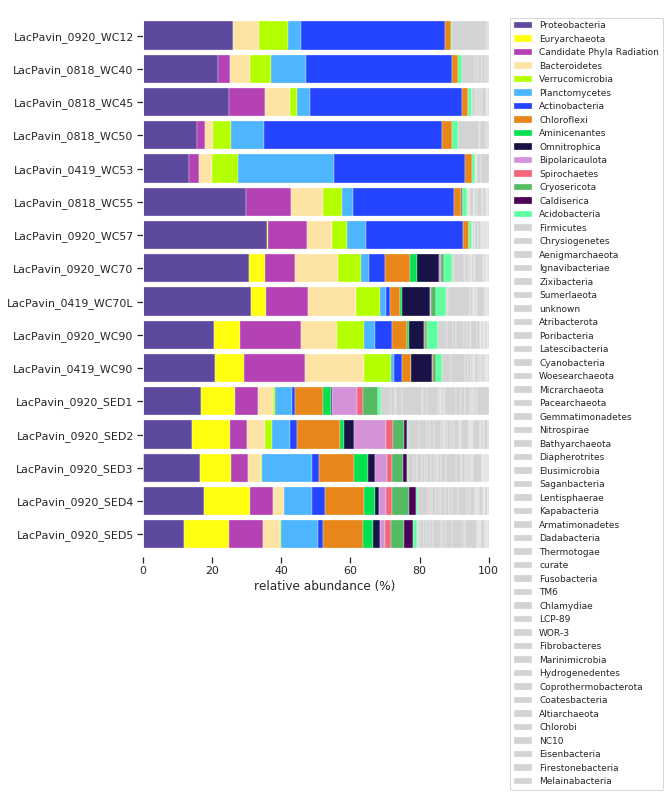

In [198]:
markermerge = markermerge.merge(cmerge[["species_group","longest_scaf", "adjusted_taxonomy"]], how="left", left_on="Contig", right_on="longest_scaf").fillna("None")
markersub = markermerge[["Sample", "adjusted_taxonomy", "perc_relative_coverage"]]
markergb = markersub.groupby(["Sample","adjusted_taxonomy"], as_index=False).aggregate({"perc_relative_coverage":"sum"})
markergb["run"] = markergb["Sample"].apply(revert_name)
markergb = markergb.drop("Sample", axis=1)
markergb.columns = ["phylum", "perc_total", "run"]

# modify color palette
ggcolors["Candidate Phyla Radiation"] = "#B542B5"
ggcolors["Proteobacteria"] = "#5d499e"
ggcolors["Omnitrophica"] = "#191247"
ggcolors["Cryosericota"] = "#54ba63"

for item in markergb["phylum"].unique():
    if item not in ggcolors.keys():
        ggcolors[item] = generate_color()

# plot
plot_stacked_bar(markergb, ggcolors)
plt.savefig(rootdir + "figures/marker_community_composition.svg", 
    format="svg", bbox_inches="tight", dpi=300)

### site similarity

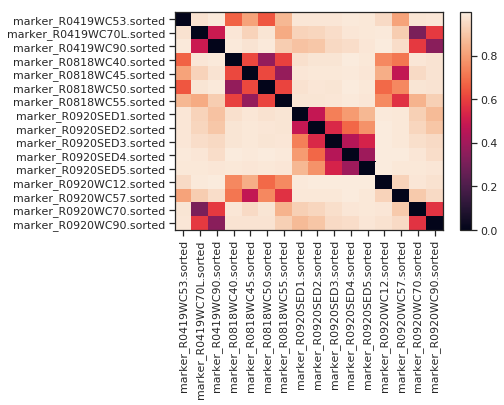

In [199]:
markerpiv = markermerge.pivot("Sample", "Contig", "perc_relative_coverage").fillna(0)
bray = beta_diversity("braycurtis", markerpiv, list(markerpiv.index))
bray

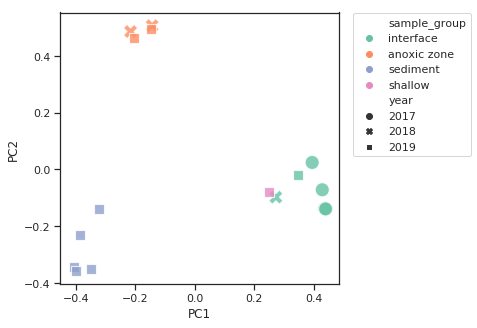

In [200]:
# then use skbio to do pcoA
pcoa_results = pcoa(bray)
pcresults = pd.DataFrame(pcoa_results.samples)
pcresults["sample"] = markerpiv.index
pcresults["sample_group"] = pcresults["sample"].apply(categorize)
pcresults["year"] = pcresults["sample"].apply(lambda x: int("20" + x.split("_")[1][3:5]) - 1)


#plot
sns.set_style("ticks")
plt.figure(figsize=[5,5])
sns.scatterplot("PC1", "PC2", data=pcresults, hue="sample_group", 
                style="year", palette="Set2", s=200, alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(rootdir + "figures/pca.svg", format="svg")
plt.show()

In [201]:
pcoa_results.proportion_explained[0:2]

PC1    0.309755
PC2    0.248085
dtype: float64

### write out supp table

In [204]:
table_s2 = markermerge[["Sample", "species_group","Contig", "perc_relative_coverage", "adjusted_taxonomy"]]
table_s2["sample"] = table_s2["Sample"].apply(revert_name)
table_s2 = table_s2.drop("Sample", axis=1).rename(columns={"Contig":"representative_scaffold", "adjusted_taxonomy":"curated_taxonomy"})
table_s2[["sample", "species_group","representative_scaffold", "curated_taxonomy", "perc_relative_coverage"]].sort_values(["sample", "curated_taxonomy"]).to_csv(rootdir + "tables/marker_gene_supp.tsv", sep="\t", index=False)

# genome set

In [ ]:
cmdir(rootdir + "/genomes/remapping")

### run remapping

In [ ]:
# combine genomes
with open(rootdir + "/genomes/remapping/all_genomes.fa", "w") as outfile:
    for genome in glob.glob(rootdir + "/genomes/renamed_genomes/*"):
        for record in SeqIO.parse(open(genome), "fasta"):
            outfile.write(">" + record.description.split(" ")[0] + "\n" + str(record.seq) + "\n")

In [ ]:
#remap reads from all samples
with open(rootdir + "/scripts/remapGenomes.sh","w") as outfile:
    
    #build bt index
    call = "/shared/software/bin/bowtie2-build " + rootdir + "/genomes/remapping/all_genomes.fa " + \
        rootdir + "genomes/remapping/all_genomes.fa"
    outfile.write(call + "\n")

    for biome in reads:
        
        for read_tuple in reads[biome]:

            # read shorthand
            rcode = "R" + "".join(os.path.basename(read_tuple[0]).split("_")[1:3])
            filecode = rootdir + "/genomes/remapping/genomes_" + rcode
            # generate mapping
            mapping = "/shared/software/bin/bowtie2 -p 48 -x " + rootdir + "/genomes/remapping/all_genomes.fa -1 " + \
                read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
                " | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + filecode + ".bam"
            outfile.write(mapping + "\n")
            # generate sorted bam + idx
            sort = "/shared/software/bin/samtools sort --threads 45 " + filecode + ".bam > " + filecode + ".sorted.bam"
            index = "/shared/software/bin/samtools index -@ 48 " + filecode + ".sorted.bam"
            outfile.write(sort + "\n" + index + "\n")  

In [ ]:
with open(rootdir+"/scripts/getGenomeCov.sh", "w") as outfile:

    for thresh in range(94,100):
        
        coverm = "coverm genome --genome-fasta-directory " + rootdir + "/genomes/renamed_genomes/ -x fna --min-read-percent-identity " + \
            str(thresh/float(100)) + " --min-covered-fraction 0 --output-format sparse -b " + rootdir + "/genomes/remapping/*sorted.bam -m" + \
            " count mean covered_fraction length rpkm > " + rootdir + "/genomes/remapping/coverage_table." + str(thresh) + ".csv"
        outfile.write(coverm + "\n")

In [57]:
# read in cov files
cmresults = []

for result in glob.glob(rootdir + "/genomes/remapping/coverage*"):
    
    table = pd.read_csv(result, sep="\t")
    table["threshold"] = os.path.basename(result).split(".")[-2]
    cmresults.append(table)

covresults = pd.concat(cmresults)

### process

In [88]:
# downselect 95 threshold + remove 70S
# remove <50 covered fraction FIRST
covsub = covresults[(covresults["threshold"]=="95") & (~covresults["Sample"].str.contains("70S")) & \
                    (covresults["Covered Fraction"]>=0.50)]
# calculate relative coverage
covsums = covsub.groupby(["Sample"], as_index=False).aggregate({"Mean":"sum"})
covsums.columns = ["Sample", "total_genome_coverage"]
covmerge = covsub.merge(covsums, how="left", on= "Sample")
covmerge["relative_coverage"] = covmerge.apply(lambda x: x["Mean"]/x["total_genome_coverage"], axis=1)
covmerge["perc_relative_coverage"] = covmerge["relative_coverage"].apply(lambda x: 100*x)
covmerge["log_relative_coverage"] = covmerge["relative_coverage"].apply(lambda x: math.log10(x) if x != 0 else 0)

In [89]:
#manipulate taxonomy
metadata = pd.read_csv(rootdir + "tables/jaffe_table_s1_curated.tsv", sep="\t")
covmerge = covmerge.merge(metadata[["genome_name", "gtdbtk_taxonomy"]], how="left", left_on="Genome", right_on="genome_name")
covmerge.head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,RPKM,threshold,sample_reads,perc_reads,log_perc_reads,total_genome_coverage,relative_coverage,perc_relative_coverage,log_relative_coverage,genome_name,gtdbtk_taxonomy
0,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Rhizobiales_65_19,28591,1.072806,0.624130,3791592,0.156232,95,94496416,0.030256,-1.519186,2157.79834,0.000497,0.049718,-3.303489,LacPavin_0818_WC50_Rhizobiales_65_19,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...
1,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Alphaproteobacteria_64_9,107597,2.877554,0.922890,5309877,0.419834,95,94496416,0.113864,-0.943615,2157.79834,0.001334,0.133356,-2.874987,LacPavin_0818_WC50_Alphaproteobacteria_64_9,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...
2,genomes_R0419WC53.sorted,LacPavin_0920_WC57_Actinobacteria_51_13,666761,49.802390,0.998688,1956235,7.061735,95,94496416,0.705594,-0.151445,2157.79834,0.023080,2.308019,-1.636761,LacPavin_0920_WC57_Actinobacteria_51_13,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...
3,genomes_R0419WC53.sorted,LacPavin_0818_WC50_Planctomycetales_55_36,446817,12.229828,0.998753,5237937,1.767387,95,94496416,0.472840,-0.325286,2157.79834,0.005668,0.566773,-2.246591,LacPavin_0818_WC50_Planctomycetales_55_36,d__Bacteria;p__Planctomycetota;c__Planctomycet...
4,genomes_R0419WC53.sorted,LacPavin_0419_WC53_Gammaproteobacteria_39_9,123126,8.266907,0.998887,2162034,1.179912,95,94496416,0.130297,-0.885066,2157.79834,0.003831,0.383118,-2.416668,LacPavin_0419_WC53_Gammaproteobacteria_39_9,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...


### heatmaps - all orgs

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import LogNorm

In [80]:
# cluster genomes based on log rel cov
logpiv = covmerge.pivot("Sample", "Genome", "log_relative_coverage").fillna(0)
col_clustering = linkage(logpiv.transpose(), method='average', metric="euclidean")
col_idx = dendrogram(col_clustering, no_plot=True)["ivl"]
cols = [logpiv.columns[int(i)] for i in col_idx]

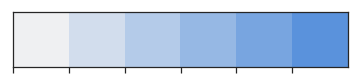

In [83]:
new_pal = sns.light_palette((250, 70, 60), input="husl")
sns.palplot(new_pal)

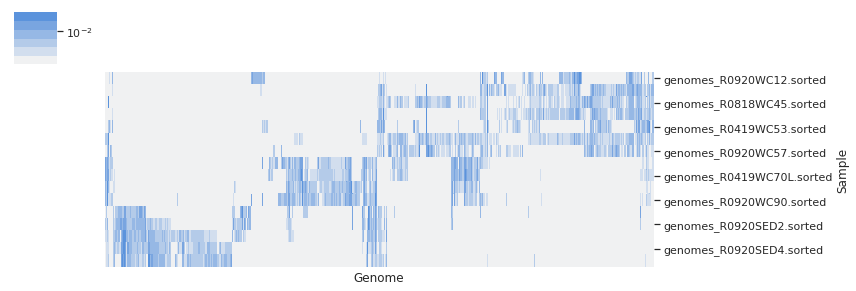

In [86]:
# prep matrix
relpiv = covmerge.pivot("Sample", "Genome", "relative_coverage").reset_index().fillna(covmerge["relative_coverage"].min()*1.01)
relpiv_sorted = relpiv.sort_values(by="Sample", key=lambda col: [x.split(".")[0].split("_R")[1][5:] for x in col])
relpiv_sorted.index = relpiv_sorted["Sample"]
relpiv_sorted = relpiv_sorted.drop("Sample", axis=1)
relpiv_sorted = relpiv_sorted[cols]

# plot
sns.clustermap(relpiv_sorted,cmap=new_pal,norm=LogNorm(covmerge["relative_coverage"].min(), covmerge["relative_coverage"].max()), 
    row_cluster=False,col_cluster=False, xticklabels=False, figsize=(12,4), dendrogram_ratio=(0.1,0.2))
#plt.savefig(rootdir + "figures/heatmap_all.svg", format="svg")
plt.show()

### heatmap - cpr only

In [136]:
cpr_groups = pd.read_csv("/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/trees/tree_order.txt", header=None).fillna("None")
cpr_groups.columns = ["lineage", "group"]
cpr_group_dict = {row["lineage"]:row["group"] for key, row in cpr_groups.iterrows()}

In [141]:
cpr2clade={}
for key, row in metadata[metadata["gtdbtk_taxonomy"].str.contains("Patesci")].iterrows():
    
    if row["curated_taxonomy"] in ["CPR", "Parcubacteria", "Azambacteria", 
        "Doudnabacteria", "Katanobacteria", "Portnoybacteria"]:
        cpr2clade[row["genome_name"]] = "other"
    elif cpr_group_dict[row["curated_taxonomy"]]!='None':
        cpr2clade[row["genome_name"]] = cpr_group_dict[row["curated_taxonomy"]]
    else: cpr2clade[row["genome_name"]] = row["curated_taxonomy"]

In [142]:
cpr2color = {'None': 'white',
             'Saccharibacteria': '#fbb463',
             'Peregrinibacteria': '#bfbada',
             'Parcubacteria_2': '#d9d9d8',
             'Parcubacteria_1': '#b4d66c',
             'Microgenomates': '#cde6c4',
             'Parcubacteria_3': '#8ed2c6',
             'Parcubacteria_4': '#fcf6b5',
             'Absconditabacteria': "#81b2d3",
             'Berkelbacteria':'#facee1',
             'Moranbacteria':'#bc80b8',
             'other': 'white'}

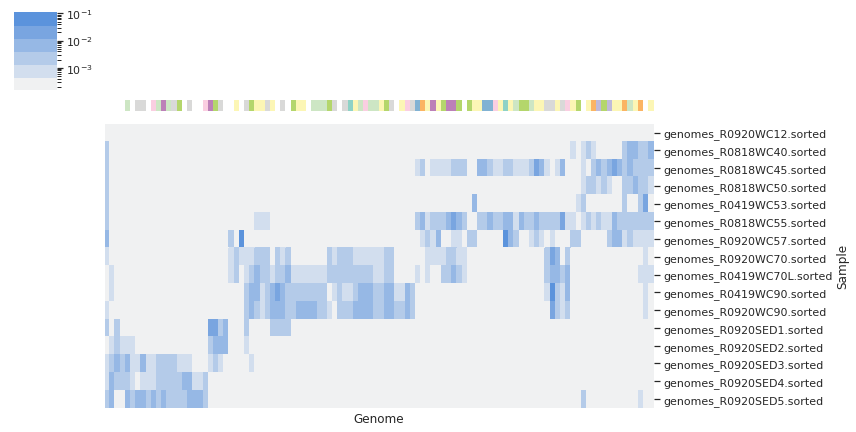

In [144]:
# subset original clustering
cpr_list = metadata[metadata["gtdbtk_taxonomy"].str.contains("Patesci")]["genome_name"].to_list()
cprpiv = relpiv_sorted[[col for col in relpiv_sorted.columns if col in cpr_list]]
gcolorA = [cpr2color[cpr2clade[genome]] for genome in cprpiv.columns]
sns.clustermap(cprpiv,cmap=new_pal,method="average", norm=LogNorm(covmerge["relative_coverage"].min(), covmerge["relative_coverage"].max()),
    row_cluster=False, col_colors=gcolorA,col_cluster=False, xticklabels=False, figsize=(12,6), dendrogram_ratio=(0.1,0.2))
plt.savefig(rootdir+"figures/cpr_heatmap.svg", format="svg")
plt.show()

### supp table

In [157]:
covbase = covmerge[covmerge["gtdbtk_taxonomy"].str.contains("Patesci")]
covbase["sample"] = covbase["Sample"].apply(revert_name)
cpiv = covbase.pivot("genome_name", "sample", "perc_relative_coverage").reset_index().fillna("not detected")
sample_order = sorted([item for item in covbase["sample"].unique() if \
        "SED" not in item], key=lambda x: x.split("_")[-1], reverse=False) + \
        sorted([item for item in covbase["sample"].unique() if "SED" in item], reverse=False)   
cpiv[["genome_name"] + sample_order].sort_values("genome_name").to_csv(rootdir + "tables/supp_cpr_coverages.tsv", sep="\t", index=False)

### output for pclust

In [160]:
cpr_color_df = pd.DataFrame.from_dict(cpr2color, orient="index").reset_index()
cpr_color_df.columns = ["lineage", "color"]

In [170]:
# write out rel covs and order for pclust plot
sc_sub = covmerge[covmerge["gtdbtk_taxonomy"].str.contains("Patesci")][["Sample", "Genome", "relative_coverage"]]
sc_sub["compartment"] = sc_sub["Sample"].apply(categorize)
sc_gb = sc_sub.groupby(["Genome", "compartment"], as_index=False).aggregate({"relative_coverage": "median"})
sc_piv = sc_gb.pivot("Genome", "compartment", "relative_coverage").fillna(0).reset_index()
sc_piv.columns = ["genome", "anoxic", "interface", "sediment"]
sc_piv["position"] = sc_piv["genome"].apply(lambda x: list(cprpiv.columns).index(x))
sc_piv["lineage"] = sc_piv["genome"].map(cpr2clade)
sc_piv = sc_piv.merge(cpr_color_df, how="left", on="lineage")
sc_piv.sort_values("position").to_csv(rootdir + "tables/cpr_heatmap_order.tsv", sep="\t", index=False)